In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

from exp.nb_05b import *

# Get data

In [2]:
x_train,y_train,x_valid,y_valid= get_data_normalized()

train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

In [3]:
??get_data_normalized

In [4]:
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy


data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

bs,nh,c

(512, 50, 10)

# Convnet

In [8]:
# Create 'Lambda' module for pytorch: used for some basic function (e.g. reshape) and can be put in nn.Sequential
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

def flatten(x):      return x.view(x.shape[0], -1)
def mnist_resize(x): return x.view(-1, 1, 28, 28)

In [10]:
x_train.shape

torch.Size([60000, 784])

In [9]:
mnist_resize(x_train).shape

torch.Size([60000, 1, 28, 28])

In [11]:
flatten(mnist_resize(x_train)).shape

torch.Size([60000, 784])

In [13]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
        nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
        nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
        nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32,data.c)
    )


In [15]:
model = get_cnn_model(data)
model

Sequential(
  (0): Lambda()
  (1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (2): ReLU()
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (8): ReLU()
  (9): AdaptiveAvgPool2d(output_size=1)
  (10): Lambda()
  (11): Linear(in_features=32, out_features=10, bias=True)
)

In [16]:
cbfs = [Recorder, partial(AvgStatsCallback,accuracy)]

In [18]:
loss_func

<function torch.nn.functional.cross_entropy(input, target, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')>

In [20]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [21]:
%time run.fit(1, learn)

train: [0.6877468098958334, tensor(0.7809)]
valid: [0.84636826171875, tensor(0.7229)]
CPU times: user 9.05 s, sys: 5.9 s, total: 15 s
Wall time: 3.77 s


# Using CUDA callback

A flexible way: Determine cuda device for each callback -> can use different cuda device for each callback (good for multi-GPU training?)

```python
device = torch.device('cuda',0)

class CudaCallback(Callback):
    def __init__(self,device): self.device=device
    def begin_fit(self): self.model.to(self.device)
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.to(self.device),self.yb.to(self.device)

```

In [24]:
# Convenient way: 1 cuda device for all callbacks at once. Determine cuda device before hand

device = torch.device('cuda',0)
torch.cuda.set_device(device)

class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda() # send model to cuda at the beginning of training
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda() # send batch to cuda

In [25]:
cbfs = [Recorder, partial(AvgStatsCallback,accuracy),CudaCallback]

In [26]:
model = get_cnn_model(data)
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [28]:
%time run.fit(1, learn)

train: [0.5994508463541667, tensor(0.8114, device='cuda:0')]
valid: [1.01709287109375, tensor(0.6723, device='cuda:0')]
CPU times: user 744 ms, sys: 76.5 ms, total: 820 ms
Wall time: 822 ms


In [29]:
# combine conv2d and relu into one
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

In [32]:
# custom view for resizing 2d array into 3d imgs
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb) # with order 2, this will be applied AFTER cuda callback, at beginning of batch

def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

In [33]:
mnist_view = view_tfm(1,28,28) 
mnist_view # this is the tfm func to be passed to BatchTransformXCallback

<function __main__.view_tfm.<locals>._inner(x)>

In [34]:
cbfs

[exp.nb_05b.Recorder,
 functools.partial(<class 'exp.nb_05b.AvgStatsCallback'>, <function accuracy at 0x7f8c46c13378>),
 __main__.CudaCallback]

In [37]:
cbfs.append(partial(BatchTransformXCallback, mnist_view))

In [38]:
cbfs

[exp.nb_05b.Recorder,
 functools.partial(<class 'exp.nb_05b.AvgStatsCallback'>, <function accuracy at 0x7f8c46c13378>),
 __main__.CudaCallback,
 functools.partial(<class '__main__.BatchTransformXCallback'>, <function view_tfm.<locals>._inner at 0x7f8c46fe30d0>)]

# Rewrite cnn layers and model

In [39]:
nfs = [8,16,32,32]

In [41]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3) for i in range(len(nfs)-1)
        # why for 1st layer, kernel size is 5 (bigger) instead of 2 or 3 (smaller).
        # because: e.g for kernel size 2, and 1 channel img, we have 2x2x1=4 inputs, and with 8 channels kernel, 
        # we will have 8 outputs when the 2x2x8 kernel is applied to a portion of the image
        # 4 inputs -> 8 outputs meaning we are trying to generate more information than it already has -> bad
        # Solution: We can increase kernel size from 2 to 5, so we now have 5x5x1=25 inputs and 8 outputs
        # which means now we can condense the information/pick out only interesting information to output
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

In [42]:
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [43]:
model = get_cnn_model(data, nfs)
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [48]:
learn,run = get_runner(model, data, lr=0.2, cbs=cbfs)

In [49]:
run.fit(3, learn)

train: [0.16262819010416665, tensor(0.9502, device='cuda:0')]
valid: [0.49059609375, tensor(0.8462, device='cuda:0')]
train: [0.15084401041666667, tensor(0.9536, device='cuda:0')]
valid: [0.467985498046875, tensor(0.8614, device='cuda:0')]
train: [0.14091280924479166, tensor(0.9576, device='cuda:0')]
valid: [0.437481982421875, tensor(0.8744, device='cuda:0')]


# Keep track of mean and std of each activation

In [50]:
# break nn.Sequential into list of layers using nn.ModuleList
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            if self.training:
                self.act_means[i].append(x.data.mean())
                self.act_stds [i].append(x.data.std ())
        return x
    
    def __iter__(self): return iter(self.layers)

In [66]:
nfs

[8, 16, 32, 32]

In [69]:
model =  SequentialModel(*get_cnn_layers(data, nfs))
learn,run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [73]:
model.layers

ModuleList(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [70]:
run.fit(2, learn)

train: [2.1695563802083333, tensor(0.1998, device='cuda:0')]
valid: [2.0464458984375, tensor(0.2880, device='cuda:0')]
train: [0.9011220052083333, tensor(0.7071, device='cuda:0')]
valid: [0.92034052734375, tensor(0.7024, device='cuda:0')]


Plot activation mean across layers

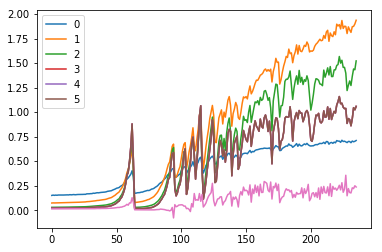

In [71]:
for l in model.act_means: plt.plot(l)
plt.legend(range(6));

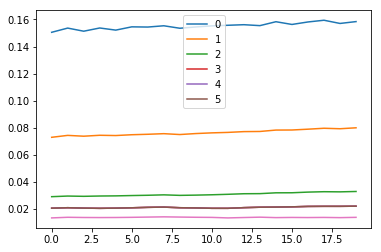

In [75]:
for l in model.act_means: plt.plot(l[:20])
plt.legend(range(6));

There are 'jump' patterns where activations' means jump to almost 1 then back

First 20 iterations (batches) seems to be okay though

Plot activation std across layers

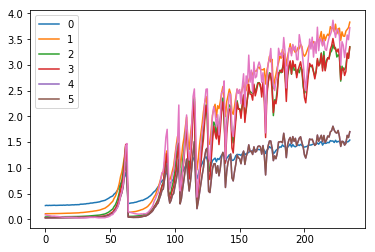

In [74]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(6));

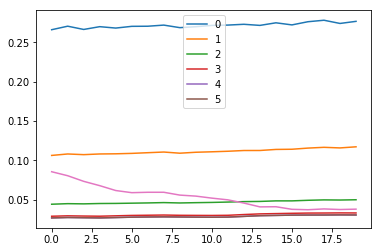

In [76]:
for l in model.act_stds: plt.plot(l[:20])
plt.legend(range(6));

Std got nowhere close to 1, and worst at last layers. At last layers std~=0, meaning activations are all close to 0, thus results in very small gradient when calculating grad_wrt_w for weight update -> vanishing gradient

# Using hooks

In [77]:
cbfs

[exp.nb_05b.Recorder,
 functools.partial(<class 'exp.nb_05b.AvgStatsCallback'>, <function accuracy at 0x7f8c46c13378>),
 __main__.CudaCallback,
 functools.partial(<class '__main__.BatchTransformXCallback'>, <function view_tfm.<locals>._inner at 0x7f8c46fe30d0>)]

In [78]:
data

In [92]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [82]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [86]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

In [87]:
# func to be passed to register_forward_hook: to decide what to do at one layer inp/outp
def append_stats(i, mod, inp, outp):
    if mod.training:
        act_means[i].append(outp.data.mean())
        act_stds [i].append(outp.data.std())

In [88]:
#register hook at each layer in model
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

In [89]:
run.fit(2, learn)

train: [2.0610565104166665, tensor(0.2539, device='cuda:0')]
valid: [1.93878984375, tensor(0.3511, device='cuda:0')]
train: [0.741404296875, tensor(0.7582, device='cuda:0')]
valid: [1.06941416015625, tensor(0.6414, device='cuda:0')]


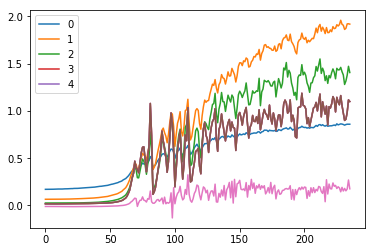

In [90]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

# Hook class: to remove hook when deleted

In [97]:
for i in model.children(): # the same with for i in model: print(i)
    print(i) 
    print('-')

Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (1): ReLU()
)
-
Sequential(
  (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)
-
Sequential(
  (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)
-
Sequential(
  (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)
-
AdaptiveAvgPool2d(output_size=1)
-
Lambda()
-
Linear(in_features=32, out_features=10, bias=True)
-


In [99]:
def children(m): return list(m.children()) # turn model layers into list so we can sublist them 

class Hook():# define a hook class for one hook at each layer
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

def append_stats(hook, mod, inp, outp):# pass in Hook obj in register_forward_hook function
    if not hasattr(hook,'stats'): hook.stats = ([],[])  # store mean and std as obj attributes
    means,stds = hook.stats
    if mod.training:
        means.append(outp.data.mean())
        stds .append(outp.data.std())

In [104]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [105]:
hooks = [Hook(l, append_stats) for l in children(model[:4])] # hook only the first 4, which are conv2d+relu layers

In [106]:
run.fit(2, learn)

train: [1.873344140625, tensor(0.3330, device='cuda:0')]
valid: [2.024685546875, tensor(0.3598, device='cuda:0')]
train: [0.641756640625, tensor(0.7968, device='cuda:0')]
valid: [0.89331494140625, tensor(0.7232, device='cuda:0')]


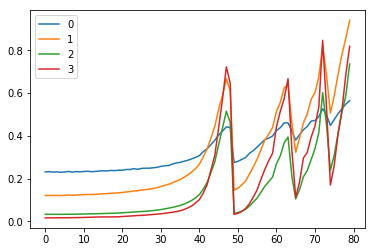

In [111]:
for h in hooks:
    plt.plot(h.stats[0][:80]) #plot mean, 1st 80 batches
    h.remove() # remove hook since we are done
plt.legend(range(4));

# Hooks: to contain a list of hook

Design to make this look like a numpy array: slice (arr[:5]), list of indices, mask of indices ...

In [125]:
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
#         print(idx)
        try: return self.items[idx]
        except TypeError:
            if isinstance(idx[0],bool):
                assert len(idx)==len(self) # bool mask
                return [o for m,o in zip(idx,self.items) if m]
            return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): 
        return iter(self.items) 
        # so if we have a ListContainer obj (e.g. lc), we can do ```for i in lc``` instead of ```for i in lc.items```
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

In [126]:
temp = ListContainer(range(10))
temp

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [119]:
temp[0],temp[1,2] # __getitem__ receive 1,2 as tuple, i.e. (1,2)

(0, [1, 2])

In [128]:
temp[1,2], temp[[1,2]]

([1, 2], [1, 2])

In [130]:
temp[[False]*6 + [True,False,True,False]]

[6, 8]

In [131]:
temp[0] = 1
temp

ListContainer (10 items)
[1, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [135]:
del temp[2]
temp

ListContainer (9 items)
[1, 1, 3, 4, 5, 6, 7, 8, 9]

In [136]:
for i in temp:
    print(i)

1
1
3
4
5
6
7
8
9


Now we can write our hooks using this structure

In [132]:
from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms]) # use only 1 func for all hooks
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self: h.remove()

In [133]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [134]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7f8bd0a05438>, <__main__.Hook object at 0x7f8bd0a05940>, <__main__.Hook object at 0x7f8c05a54630>, <__main__.Hook object at 0x7f8c028c91d0>, <__main__.Hook object at 0x7f8bd0aaa978>, <__main__.Hook object at 0x7f8bd0aaa7f0>, <__main__.Hook object at 0x7f8bd0aaa860>]